In [41]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import Model
from tqdm import tqdm
from keras.models import Sequential, load_model
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras import callbacks
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model


100%|██████████| 100/100 [00:00<00:00, 230.62it/s]


Number of classes,  2


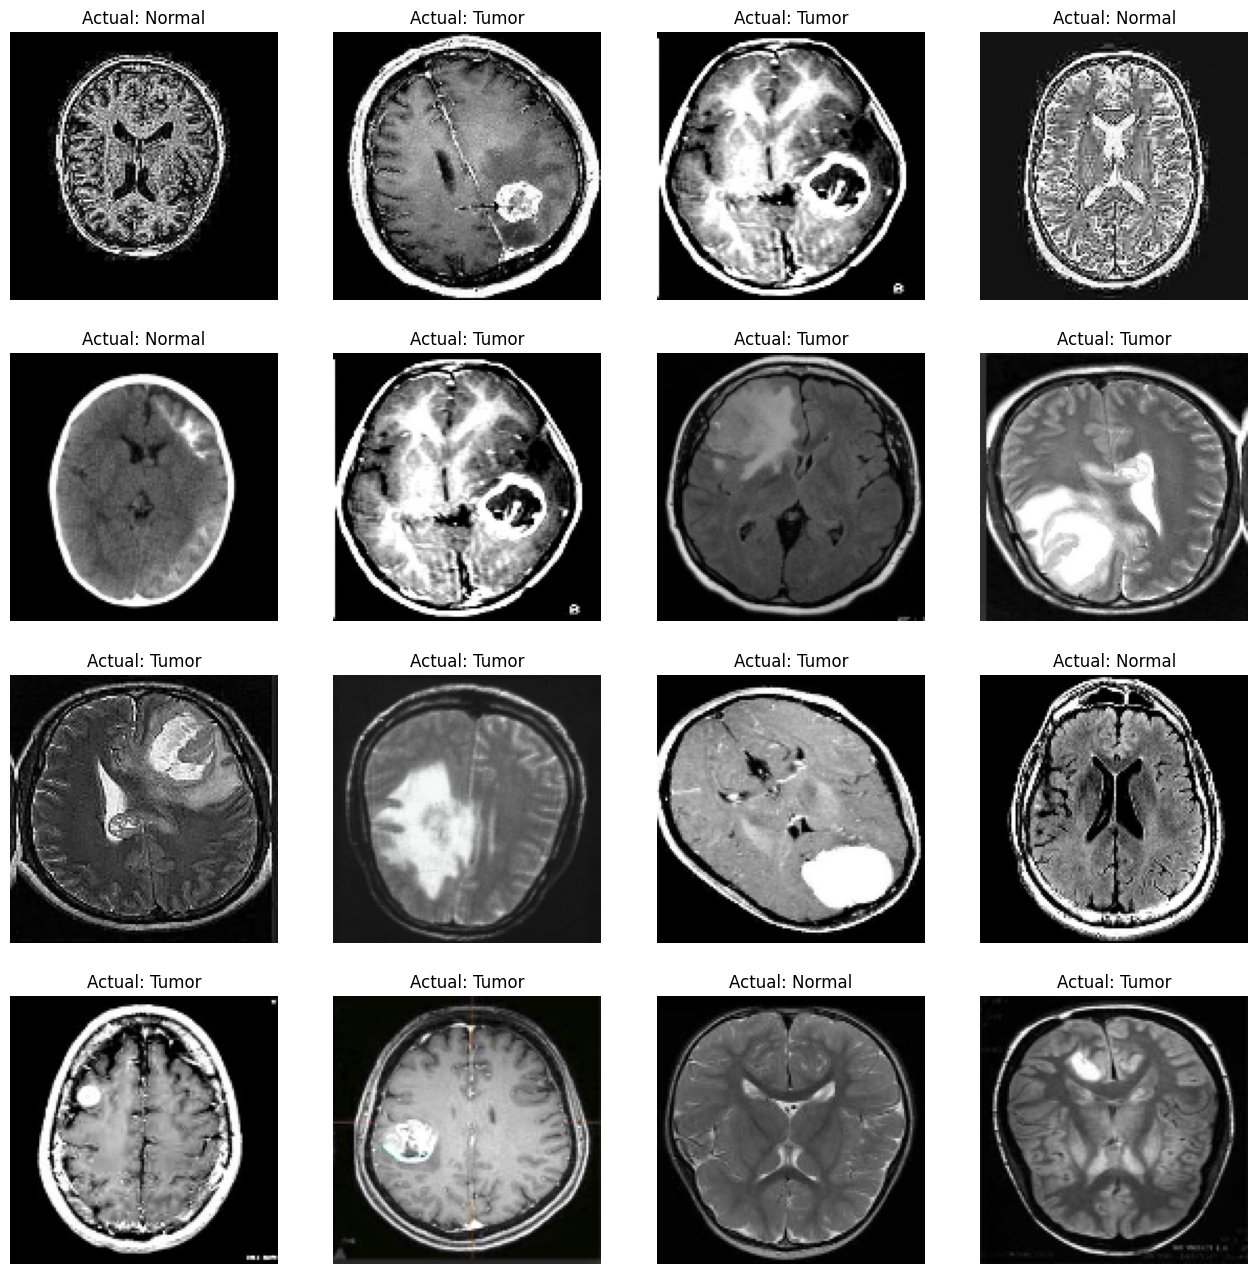

In [42]:
classes = {'Normal': 0, 'Tumor': 1}

Tumor_test=r'dataset/test'

Tumor_train=r'dataset/train/yes'
Normal_train=r'dataset/train/no'

Tumor_valid=r'dataset/valid/yes'
Normal_valid=r'dataset/valid/no'

# On définit les paramètres de la base de données
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
BATCH_SIZE=64
N_CLASSES = 2
EPOCHS = 10

def assign_label(img,class_type):
    return class_type

X = []
y = []


# Fonction permettant d'assigner un label aux images
def make_train_data(class_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,class_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMAGE_WIDTH,IMAGE_HEIGHT))
        
        X.append(np.array(img))
        y.append(str(label))

make_train_data(classes.get('Normal'), Normal_train)
make_train_data(classes.get('Tumor'), Tumor_train)

y = np.array(y)
X = np.array(X)
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=42)

X = []
y = []

make_train_data(classes.get('Normal'), Normal_valid)
make_train_data(classes.get('Tumor'),Tumor_valid)


y_valid = np.array(y)
X_valid = np.array(X)



k = len(set(y_train))
print("Number of classes, ", k)

# On normalise les données
X_train = X_train.astype('float64')/255
X_test = X_test.astype('float64')/255
X_valid = X_valid.astype('float64')/255

y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)
y_valid = to_categorical(y_valid, num_classes=2)

labels = '''Normal
Tumor
'''.split("\n")

plt.figure(figsize=(16,16))
j = 1
for i in np.random.randint(0,252,16):
    plt.subplot(4,4,j); j+=1
    plt.imshow(X_train[i],cmap = 'Greys')
    plt.axis('off')
    plt.title("Actual: {}".format(labels[np.argmax(y_train[i])]))

In [43]:
# Création des couches du réseau de neurone
i = layers.Input(shape = (X_train[0].shape))
x = layers.Conv2D(64, (3,3), activation="relu", strides=(2,2), padding="same" )(i)
x = layers.Conv2D(64, (3,3), activation="relu", strides=(2,2), padding="same" )(x)
x = layers.Conv2D(32, (3,3), activation="relu", strides=(2,2), padding="same" )(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(k, activation='softmax')(x)

#Construction du modèle:
model = Model(i, x)

model.summary()
#Compilation du modèle :
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,patience=3, min_lr=0.00001)

model.fit(X_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_data=  (X_valid,y_valid), callbacks=[reduce_lr])

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 64)        36928     
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 32)        18464     
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_9 (Dense)             (None, 256)               2097408   
                                                                 
 dropout_6 (Dropout)         (None, 256)               0   

18/18 [==============================] - 1s 25ms/step
Confusion matrix, without normalization
[[290   1]
 [  2 267]]


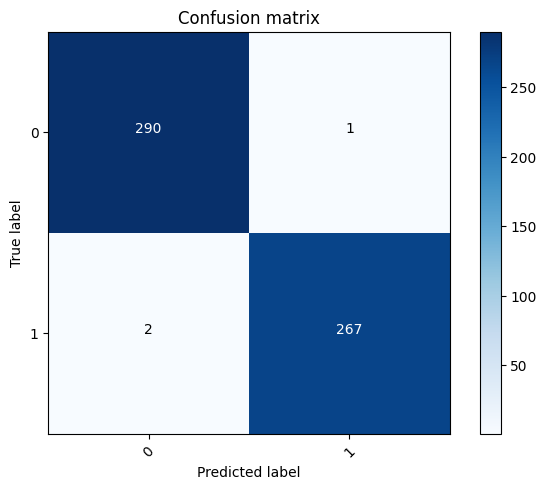

In [44]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Etape de prédiction
p_test = model.predict(X_test).argmax(axis=1)
# Matrice de confusion
cm = confusion_matrix(np.argmax(y_test, axis= 1), p_test)
plot_confusion_matrix(cm, list(range(2)))


In [45]:
def test_cnn (image):
    test =  tf.keras.preprocessing.image.load_img(image, target_size = (128, 128))
    display(test)
    test =  tf.keras.preprocessing.image.img_to_array(test)
    test = np.expand_dims(test, 0)
    result = model.predict(test/255.0)
    print("{} % chance of Brain Tumor.".format(result[0][1]*100))


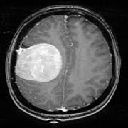

1/1 [==============================] - 0s 25ms/step
99.97811913490295 % chance of Brain Tumor.


In [46]:
# Yes 1
image1 = "dataset/test/Y1.jpg"
test_cnn(image1)

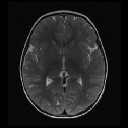

1/1 [==============================] - 0s 25ms/step
2.5625296329323533e-08 % chance of Brain Tumor.


In [47]:
image2 = "dataset/test/N1.jpeg"
test_cnn(image2)